In [104]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image  # Corrección: PIL importado correctamente
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch_snippets.torch_loader import Report
import os
import time
import xml.etree.ElementTree as ET

# Verificar si CUDA está disponible
cuda_available = torch.cuda.is_available()

# Imprimir si CUDA está disponible y la versión de CUDA
print(f"CUDA disponible: {cuda_available}")

if cuda_available:
    print(f"Versión de CUDA: {torch.version.cuda}")
    print(f"Dispositivo CUDA: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA no está disponible.")
    
# Configurar el dispositivo
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


CUDA disponible: True
Versión de CUDA: 11.8
Dispositivo CUDA: NVIDIA GeForce GTX 1060 6GB


In [105]:
def xml_to_dict(xml_path):
    # Parse the XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Extract the common image properties
    data = {
        "filename": root.find("filename").text if root.find("filename") is not None else xml_path,
        "image_width": int(root.find("./size/width").text),
        "image_height": int(root.find("./size/height").text),
        "image_channels": int(root.find("./size/depth").text),
        "objects": []
    }
    
    # Loop over all objects in the XML file
    for obj in root.findall("object"):
        obj_data = {
            "label": obj.find("name").text,
            "x1": int(obj.find("./bndbox/xmin").text),
            "y1": int(obj.find("./bndbox/ymin").text),
            "x2": int(obj.find("./bndbox/xmax").text),
            "y2": int(obj.find("./bndbox/ymax").text)
        }
        data["objects"].append(obj_data)
    
    return data


In [ ]:
# Convert human readable str label to int.
label_dict = {"Bottle": 1, "Other" : 2}
# Convert label int to human readable str.
reverse_label_dict = {1: "Bottle", 2: "Other"}

class BottlesOthersDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        """
        Inputs:
            root: str
                Path to the data folder.
            transforms: callable
                Transformations that take both the image and target as inputs.
        """
        self.root = root
        self.transforms = transforms
        # Lista de archivos de imagen (sin extensión)
        self.files = sorted([f.split(".")[0] for f in os.listdir(os.path.join(self.root, "images"))])
        # Diccionarios de etiquetas
        self.label_dict = label_dict

    def __getitem__(self, i):
        # Cargar imagen
        img_path = os.path.join(self.root, "images", self.files[i] + ".jpg")
        img = Image.open(img_path).convert("RGB")
        
        # Cargar anotaciones
        ann_path = os.path.join(self.root, "annotations", self.files[i] + ".xml")
        ann = xml_to_dict(ann_path)
        
        # Crear el target
        target = {"boxes": [], "labels": []}
        for obj in ann["objects"]:
            # Obtener coordenadas de bounding box
            target["boxes"].append([obj["x1"], obj["y1"], obj["x2"], obj["y2"]])
            # Etiqueta correspondiente
            target["labels"].append(self.label_dict[obj["label"]])
        
        # Convertir listas en tensores
        target["boxes"] = torch.as_tensor(target["boxes"], dtype=torch.float32)
        target["labels"] = torch.as_tensor(target["labels"], dtype=torch.int64)
        target["image_id"] = torch.as_tensor(i, dtype=torch.int64)
        
        # Aplicar transformaciones (si están definidas)
        if self.transforms is not None:
            img, target = self.transforms(img, target)  # Asumiendo que la función `transforms` acepta ambos
        
        return img, target

    def __len__(self):
        return len(self.files)


In [107]:
import torchvision.transforms.functional as F
import torchvision.transforms.transforms as T
class Compose:
    """
    Composes several torchvision image transforms 
    as a sequence of transformations.
    Inputs
        transforms: list
            List of torchvision image transformations.
    Returns
        image: tensor
        target: dict
    """
    def __init__(self, transforms = []):
        self.transforms = transforms
    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [108]:
class ToTensor(torch.nn.Module):
    """
    Converts a PIL image into a torch tensor.
    """
    def forward(self, image, target=None):
        image = F.pil_to_tensor(image)  # Convierte la imagen a tensor
        image = F.convert_image_dtype(image)  # Ajusta el tipo de dato para PyTorch
        return image, target


In [109]:
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    """
    Randomly flips an image horizontally.
    """
    def forward(self, image, target=None):
        if torch.rand(1) < self.p:  # Probabilidad de aplicar el flip
            image = F.hflip(image)  # Aplica el flip a la imagen
            if target is not None:
                width, _ = F.get_image_size(image)
                # Actualiza las coordenadas de las bounding boxes en `target`
                target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
        return image, target


In [110]:
def get_transform(train):
    """
    Transforms a PIL Image into a torch tensor, and performs
    random horizontal flipping of the image if training a model.
    Inputs
        train: bool
            Flag indicating whether model training will occur.
    Returns
        compose: Compose
            Composition of image transforms.
    """
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
        # Other transforms can be added here later on.
    return Compose(transforms)

In [ ]:
# Crear un conjunto de datos unificado con todos los datos disponibles
full_train_ds = BottlesOthersDataset("data/botellasAumentadas", get_transform(train=True))

# Aleatorizar los datos
indices = torch.randperm(len(full_train_ds)).tolist()

# Dividir en entrenamiento (64%), validación (16%) y prueba (20%)
train_ds = torch.utils.data.Subset(full_train_ds, indices[:int(len(indices) * 0.8)])
val_ds = torch.utils.data.Subset(full_train_ds, indices[int(len(indices) * 0.8):])
test_ds = torch.utils.data.Subset(full_train_ds, indices[int(len(indices) * 0.8):])


In [113]:
# Comprobar la longitud de cada conjunto
print(f"Train dataset length: {len(train_ds)}")
print(f"Validation dataset length: {len(val_ds)}")
print(f"Test dataset length: {len(test_ds)}")

# Imprimir algunos ejemplos (por ejemplo, los primeros 3 elementos)
for i in range(3):  # Limitar a los primeros 3 elementos para no saturar la salida
    # Obtener una imagen y su correspondiente target
    img, target = train_ds[i]
    print(f"Example {i+1} from train dataset:")
    print(f"Image size: {img.size()}")
    print(f"Target: {target}")
    print()

Train dataset length: 156
Validation dataset length: 39
Test dataset length: 39
Example 1 from train dataset:
Image size: torch.Size([3, 240, 320])
Target: {'boxes': tensor([[  1.,  18., 103., 183.]]), 'labels': tensor([1]), 'image_id': tensor(12)}

Example 2 from train dataset:
Image size: torch.Size([3, 240, 320])
Target: {'boxes': tensor([[  0.,  59., 229., 160.]]), 'labels': tensor([1]), 'image_id': tensor(87)}

Example 3 from train dataset:
Image size: torch.Size([3, 240, 320])
Target: {'boxes': tensor([[  0.,  53., 162., 176.],
        [128.,  46., 319., 239.]]), 'labels': tensor([2, 2]), 'image_id': tensor(80)}



In [114]:
# Collate image-target pairs into a tuple.
def collate_fn(batch):
    return tuple(zip(*batch))

# Crear el DataLoader para el conjunto de entrenamiento.
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=1, 
                                       shuffle=True, 
                                       collate_fn=collate_fn)

# Crear el DataLoader para el conjunto de validación.
val_dl = torch.utils.data.DataLoader(val_ds, 
                                     batch_size=1, 
                                     shuffle=False, 
                                     collate_fn=collate_fn)

# Crear el DataLoader para el conjunto de prueba.
test_dl = torch.utils.data.DataLoader(test_ds, 
                                      batch_size=1, 
                                      shuffle=False, 
                                      collate_fn=collate_fn)


In [115]:
# Imprimir el tamaño de cada DataLoader y algunas muestras de cada uno

# Verificar el DataLoader de entrenamiento
print("Train DataLoader:")
for images, targets in train_dl:
    print(f"Batch size (train): {len(images)}")
    print(f"Image size (train): {images[0].shape}")  # Tamaño de la primera imagen del lote
    print(f"Target (train): {targets[0]}")  # Primer target del lote
    break  # Solo mostramos el primer batch

# Verificar el DataLoader de validación
print("\nValidation DataLoader:")
for images, targets in val_dl:
    print(f"Batch size (val): {len(images)}")
    print(f"Image size (val): {images[0].shape}")  # Tamaño de la primera imagen del lote
    print(f"Target (val): {targets[0]}")  # Primer target del lote
    break  # Solo mostramos el primer batch

# Verificar el DataLoader de prueba
print("\nTest DataLoader:")
for images, targets in test_dl:
    print(f"Batch size (test): {len(images)}")
    print(f"Image size (test): {images[0].shape}")  # Tamaño de la primera imagen del lote
    print(f"Target (test): {targets[0]}")  # Primer target del lote
    break  # Solo mostramos el primer batch


Train DataLoader:
Batch size (train): 1
Image size (train): torch.Size([3, 240, 320])
Target (train): {'boxes': tensor([[ 18.,  51., 265., 239.]]), 'labels': tensor([1]), 'image_id': tensor(147)}

Validation DataLoader:
Batch size (val): 1
Image size (val): torch.Size([3, 240, 320])
Target (val): {'boxes': tensor([[  1.,  22., 226., 159.]]), 'labels': tensor([1]), 'image_id': tensor(167)}

Test DataLoader:
Batch size (test): 1
Image size (test): torch.Size([3, 240, 320])
Target (test): {'boxes': tensor([[ 94.,  22., 319., 159.]]), 'labels': tensor([1]), 'image_id': tensor(167)}


In [116]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

def get_object_detection_model(num_classes=3, feature_extraction=True):
    """
    Inputs:
        num_classes: int, number of classes to predict (including background as class 0).
        feature_extraction: bool, whether to freeze the pretrained weights.
    Returns:
        model: FasterRCNN
    """
    # Load the pretrained model with the updated weights argument
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)  # Use updated weights
    # Freeze pre-trained weights if feature_extraction is True
    if feature_extraction:
        for param in model.parameters():
            param.requires_grad = False
    # Replace the classifier head with one suitable for num_classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# Unbatching the data (move images and targets to the device)
def unbatch(batch, device):
    X, y = batch
    X = [x.to(device) for x in X]
    y = [{k: v.to(device) for k, v in t.items()} for t in y]
    return X, y

# Training a single batch
def train_batch(batch, model, optimizer, device):
    model.train()  # Make sure the model is in training mode
    X, y = unbatch(batch, device=device)
    optimizer.zero_grad()  # Clear the gradients
    losses = model(X, y)  # Forward pass
    loss = sum(loss for loss in losses.values())  # Calculate the total loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update the model weights
    return loss, losses

# Validation of a single batch (without updating weights)
@torch.no_grad()
def validate_batch(batch, model, device):
    """
    Evaluates a model's loss value using validation data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()  # Necesario para obtener las pérdidas
    X, y = unbatch(batch, device=device)
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    return loss, losses


In [118]:
def train_fasterrcnn(model, 
                 optimizer, 
                  n_epochs, 
              train_loader, 
        test_loader = None, 
                log = None, 
               keys = None, 
            device = "cpu"):
    """
    Trains a FasterRCNN model using train and validation 
    Dataloaders over n_epochs. 
    Returns a Report on the training and validation losses.
    Inputs
        model: FasterRCNN
        optimizer: torch optimizer
        n_epochs: int
            Number of epochs to train.
        train_loader: DataLoader
        test_loader: DataLoader
        log: Record
            torch_snippet Record to record training progress.
        keys: list
            List of strs containing the FasterRCNN loss names.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        log: Record
            torch_snippet Record containing the training records.
    """
    if log is None:
        log = Report(n_epochs)
    if keys is None:
        keys = ["loss_classifier", 
                   "loss_box_reg", 
                "loss_objectness", 
               "loss_rpn_box_reg"]
    model.to(device)
    
    for epoch in range(n_epochs):
        # Training loop
        N = len(train_loader)
        for ix, batch in enumerate(train_loader):
            loss, losses = train_batch(batch, model, optimizer, device)
            pos = epoch + (ix + 1) / N
            log.record(pos = pos, trn_loss = loss.item(), end = "\r")
            
        # Validation loop
        if test_loader is not None:
            N = len(test_loader)
            for ix, batch in enumerate(test_loader):
                # Aquí está el cambio: removiendo optimizer de la llamada
                loss, losses = validate_batch(batch, model, device)
                pos = epoch + (ix + 1) / N
                log.record(pos = pos, val_loss = loss.item(), end = "\r")
    
    log.report_avgs(epoch + 1)
    return log

In [215]:
# Crear el modelo Faster R-CNN con 3 clases (perro, gato y fondo)
model = get_object_detection_model(num_classes = 3, feature_extraction=True)  # Usar extracción de características

# Usar el optimizador de gradiente estocástico
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.001)


# Entrenar el modelo durante 10 épocas
log = train_fasterrcnn(model=model, 
                       optimizer=optimizer, 
                       n_epochs=5,  # Aumentar el número de épocas
                       train_loader=train_dl, 
                       test_loader=val_dl,
                       log=None, 
                       keys=None,
                       device=device)

EPOCH: 5.000  trn_loss: 0.130  val_loss: 0.128  (148.06s - 0.00s remaining)


In [167]:
@torch.no_grad()
def predict(model, data_loader, device):
    """
    Make predictions on a dataset using a trained model.
    
    Inputs:
        model: The trained model
        data_loader: DataLoader containing the test data
        device: Device to run predictions on (cuda/cpu)
    
    Returns:
        images: List of images
        predictions: List of prediction dictionaries
    """
    model.eval()  # Set model to evaluation mode
    images = []
    predictions = []
    
    for batch_images, _ in data_loader:
        # Move images to device
        batch_images = [img.to(device) for img in batch_images]
        # Get predictions
        batch_predictions = model(batch_images)
        # Store images and predictions
        images.extend([img.cpu() for img in batch_images])
        predictions.extend([{k: v.cpu() for k, v in pred.items()} for pred in batch_predictions])
    
    return images, predictions

def decode_prediction(prediction, score_threshold=0.4, nms_iou_threshold=0.2):
    """
    Decode and filter model predictions.
    
    Inputs:
        prediction: dict with 'boxes', 'scores', and 'labels'
        score_threshold: Minimum confidence score
        nms_iou_threshold: IoU threshold for NMS
    
    Returns:
        tuple: (boxes, labels, scores) as numpy arrays
    """
    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"]
    
    # Remove low-score predictions
    if score_threshold is not None:
        want = scores > score_threshold
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    
    # Apply NMS to remove overlapping boxes
    if nms_iou_threshold is not None and len(boxes) > 0:  # Añadido check de longitud
        want = torchvision.ops.nms(
            boxes=boxes,
            scores=scores,
            iou_threshold=nms_iou_threshold
        )
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    
    return (boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy())

def visualize_prediction(image, boxes, labels, scores, label_dict):
    """
    Visualize predictions on an image.
    
    Inputs:
        image: The input image tensor
        boxes: Predicted bounding boxes
        labels: Predicted labels
        scores: Prediction confidence scores
        label_dict: Dictionary mapping label ids to names
    """
    fig, ax = plt.subplots(figsize=[5, 5])
    ax.imshow(image.permute(1, 2, 0).numpy())
    
    for i, b in enumerate(boxes):
        rect = patches.Rectangle(
            b[:2].astype(int),
            (b[2] - b[0]).astype(int),
            (b[3] - b[1]).astype(int),
            linewidth=1,
            edgecolor="r",
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            b[0].astype(int),
            b[1].astype(int) - 5,
            f"{label_dict[labels[i]]} : {scores[i]:.3f}",
            color="r"
        )
    plt.show()

In [168]:
images, predictions = predict(model, test_dl, device)


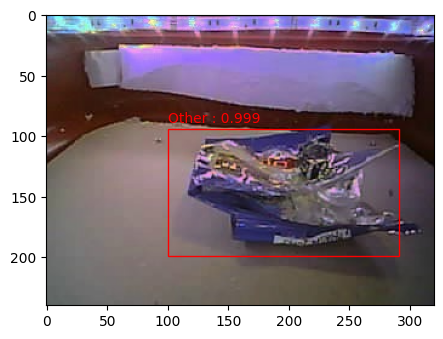

In [201]:
img_index = 28
boxes, labels, scores = decode_prediction(predictions[img_index])

fig, ax = plt.subplots(figsize=[5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth=1,
                             edgecolor="r",
                             facecolor="none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]], scores[i]),
            color="r")
plt.show()


In [216]:
import torch

# Guardar el modelo entrenado
model_file = "fasterrcnn_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),  # Pesos del modelo
    'optimizer_state_dict': optimizer.state_dict(),  # Estado del optimizador
    'num_classes': 3  # Guardar información adicional como número de clases
}, model_file)
print(f"Modelo guardado en {model_file}")


Modelo guardado en fasterrcnn_model.pth


In [221]:
# Cargar el modelo guardado
checkpoint = torch.load("fasterrcnn_model_balanced.pth", map_location=device)

# Reconstruir el modelo
num_classes = checkpoint['num_classes']  # Recuperar número de clases
model = get_object_detection_model(num_classes=num_classes, feature_extraction=False)  # No congelar pesos
model.load_state_dict(checkpoint['model_state_dict'])  # Cargar pesos
model.eval()  # Poner el modelo en modo de evaluación
model.to(device)
print("Modelo cargado y listo para inferencia")


/tmp/ipykernel_118792/3246450374.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("fasterrcnn_model_balanced.pth", map_location=device)


Modelo cargado y listo para inferencia


In [225]:
from torchvision.transforms import functional as F
from PIL import Image

# Cargar una imagen de prueba
image_path = "data/botellasAumentadas/images/2af6cdc9-20241118211559.jpg"
image = Image.open(image_path).convert("RGB")

# Preprocesar la imagen
# Convertir la imagen a un tensor
image_tensor = F.to_tensor(image).to(device)  # Convertir a tensor y mover a GPU/CPU
# Hacer la predicción
with torch.no_grad():
    predictions = model([image_tensor])  # Envolvemos la imagen en una lista

# Mostrar resultados
for idx, box in enumerate(predictions[0]['boxes']):
    score = predictions[0]['scores'][idx]
    label = predictions[0]['labels'][idx]
    if score > 0.4:  # Umbral de confianza
        print(f"Objeto {idx+1}:")
        print(f"  - Clase: {label.item()}")
        print(f"  - Confianza: {score.item()}")
        print(f"  - Caja: {box.tolist()}")



Objeto 1:
  - Clase: 1
  - Confianza: 0.9771547913551331
  - Caja: [3.802492618560791, 97.80736541748047, 187.21177673339844, 234.40541076660156]
Objeto 2:
  - Clase: 1
  - Confianza: 0.40885263681411743
  - Caja: [0.0, 166.48147583007812, 89.42438507080078, 240.00001525878906]


In [226]:
# Cargar el modelo
checkpoint = torch.load("fasterrcnn_model_balanced.pth", map_location=device)

# Reconstruir el modelo
num_classes = checkpoint['num_classes']  # Recuperar número de clases
model = get_object_detection_model(num_classes=num_classes, feature_extraction=False)  # No congelar pesos
model.load_state_dict(checkpoint['model_state_dict'])  # Cargar pesos
model.eval()  # Poner el modelo en modo de evaluación
model.to(device)

print("Modelo cargado y listo para inferencia")

from torchvision.transforms import functional as F
from PIL import Image

# Cargar una imagen de prueba
image_path = "data/botellasAumentadas/images/2af6cdc9-20241118211559.jpg"
image = Image.open(image_path).convert("RGB")

# Preprocesar la imagen
image_tensor = F.to_tensor(image).to(device)  # Convertir a tensor y mover a GPU/CPU

# Hacer la predicción
with torch.no_grad():
    predictions = model([image_tensor])  # Envolvemos la imagen en una lista

# Variables para almacenar la mejor predicción
best_prediction = None
highest_score = 0

# Procesar todas las predicciones
for idx, box in enumerate(predictions[0]['boxes']):
    score = predictions[0]['scores'][idx]
    label = predictions[0]['labels'][idx]

    # Si la confianza es mayor que la actual mejor, actualizamos
    if score > highest_score:
        highest_score = score
        best_prediction = {
            "label": label.item(),
            "score": score.item(),
            "box": box.tolist()
        }

# Determinar el resultado final
if best_prediction is None or highest_score < 0.5:  # Umbral de 50%
    prediccion = "sin accion"
else:
    if best_prediction["label"] == 1:
        prediccion = "botella"
    elif best_prediction["label"] == 2:
        prediccion = "papel"
    else:
        prediccion = "sin accion"  # Por si hay una clase inesperada

# Imprimir el resultado
print(f"Predicción final: {prediccion}")
if prediccion != "sin accion":
    print(f"  - Clase: {best_prediction['label']}")
    print(f"  - Confianza: {best_prediction['score']}")
    print(f"  - Caja: {best_prediction['box']}")


/tmp/ipykernel_118792/3591521532.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("fasterrcnn_model_balanced.pth", map_location=device)


Modelo cargado y listo para inferencia
Predicción final: botella
  - Clase: 1
  - Confianza: 0.9771547913551331
  - Caja: [3.802492618560791, 97.80736541748047, 187.21177673339844, 234.40541076660156]


In [229]:
model_file = "fasterrcnn_model1.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'num_classes': 3  # Número de clases
}, model_file)


In [64]:
torch.cuda.empty_cache()
